### Pacotes


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from statsmodels.stats.outliers_influence import variance_inflation_factor


### EDA


In [2]:
#carrega a base

df = pd.read_excel("Correlação NPS Mensal (Relacional) 2.xlsx")

In [3]:
# ajustar mês para formato adequado

df['Mês'] = pd.to_datetime(df['Mês'])

In [4]:
# eliminando variáveis com menos de 10% das observações do df

threshold = len(df) * 0.5
colunas_a_manter = [column for column in df.columns if df[column].count() >= threshold]

df_filtrado = df[colunas_a_manter]

In [5]:
# preenchendo os valores nulos com 0

df_filtrado = df_filtrado.fillna(0)

In [6]:
# trocando valores 0 pela média

for column in df_filtrado.columns:
    if np.issubdtype(df_filtrado[column].dtype, np.number):
        column_mean = df_filtrado[column][df_filtrado[column] != 0].mean()
        df_filtrado[column] = df_filtrado[column].replace(0, column_mean)

In [23]:
df.columns

Index(['Mês', 'NPS_MENSAL', 'Giro de Carteira',
       '%_difer_tx_concessao_coop_x_mercado', '%_cadastro_atual',
       'media_tempo_fila', 'media_tempo_atendimento', '%_vinculacao_boa',
       '%_vinculacao_media', '%_vinculacao_baixa', '%_vinculacao_baixissima',
       '%_nivel_serv_30_seg', '%_auto_atendimento', '%_inativo_preinativo',
       '%_coop_ deslig_bacen', 'media_consumo_cartao',
       'media_limite_credito_x_motor',
       'media_tempo_liberacao_x_esteira_credito', '%_utilizacao_cartao',
       '%_motor_x_efetivado_cartao', '%_nota_qualid_atendim_recuper_credito',
       'Fraudes Qtde', 'Fraudes Volume', '%_custo_medio_captacao_recurso_ext',
       'csat_presencial', '%_registro_crm', '%_abandono_atend', 'SLA_atend',
       'TME_atend', '%_transferencia_cr_salario', '%_cr_aprovado_x_efetivado',
       '%_turnover', 'nota_app_androide'],
      dtype='object')

### Correlação


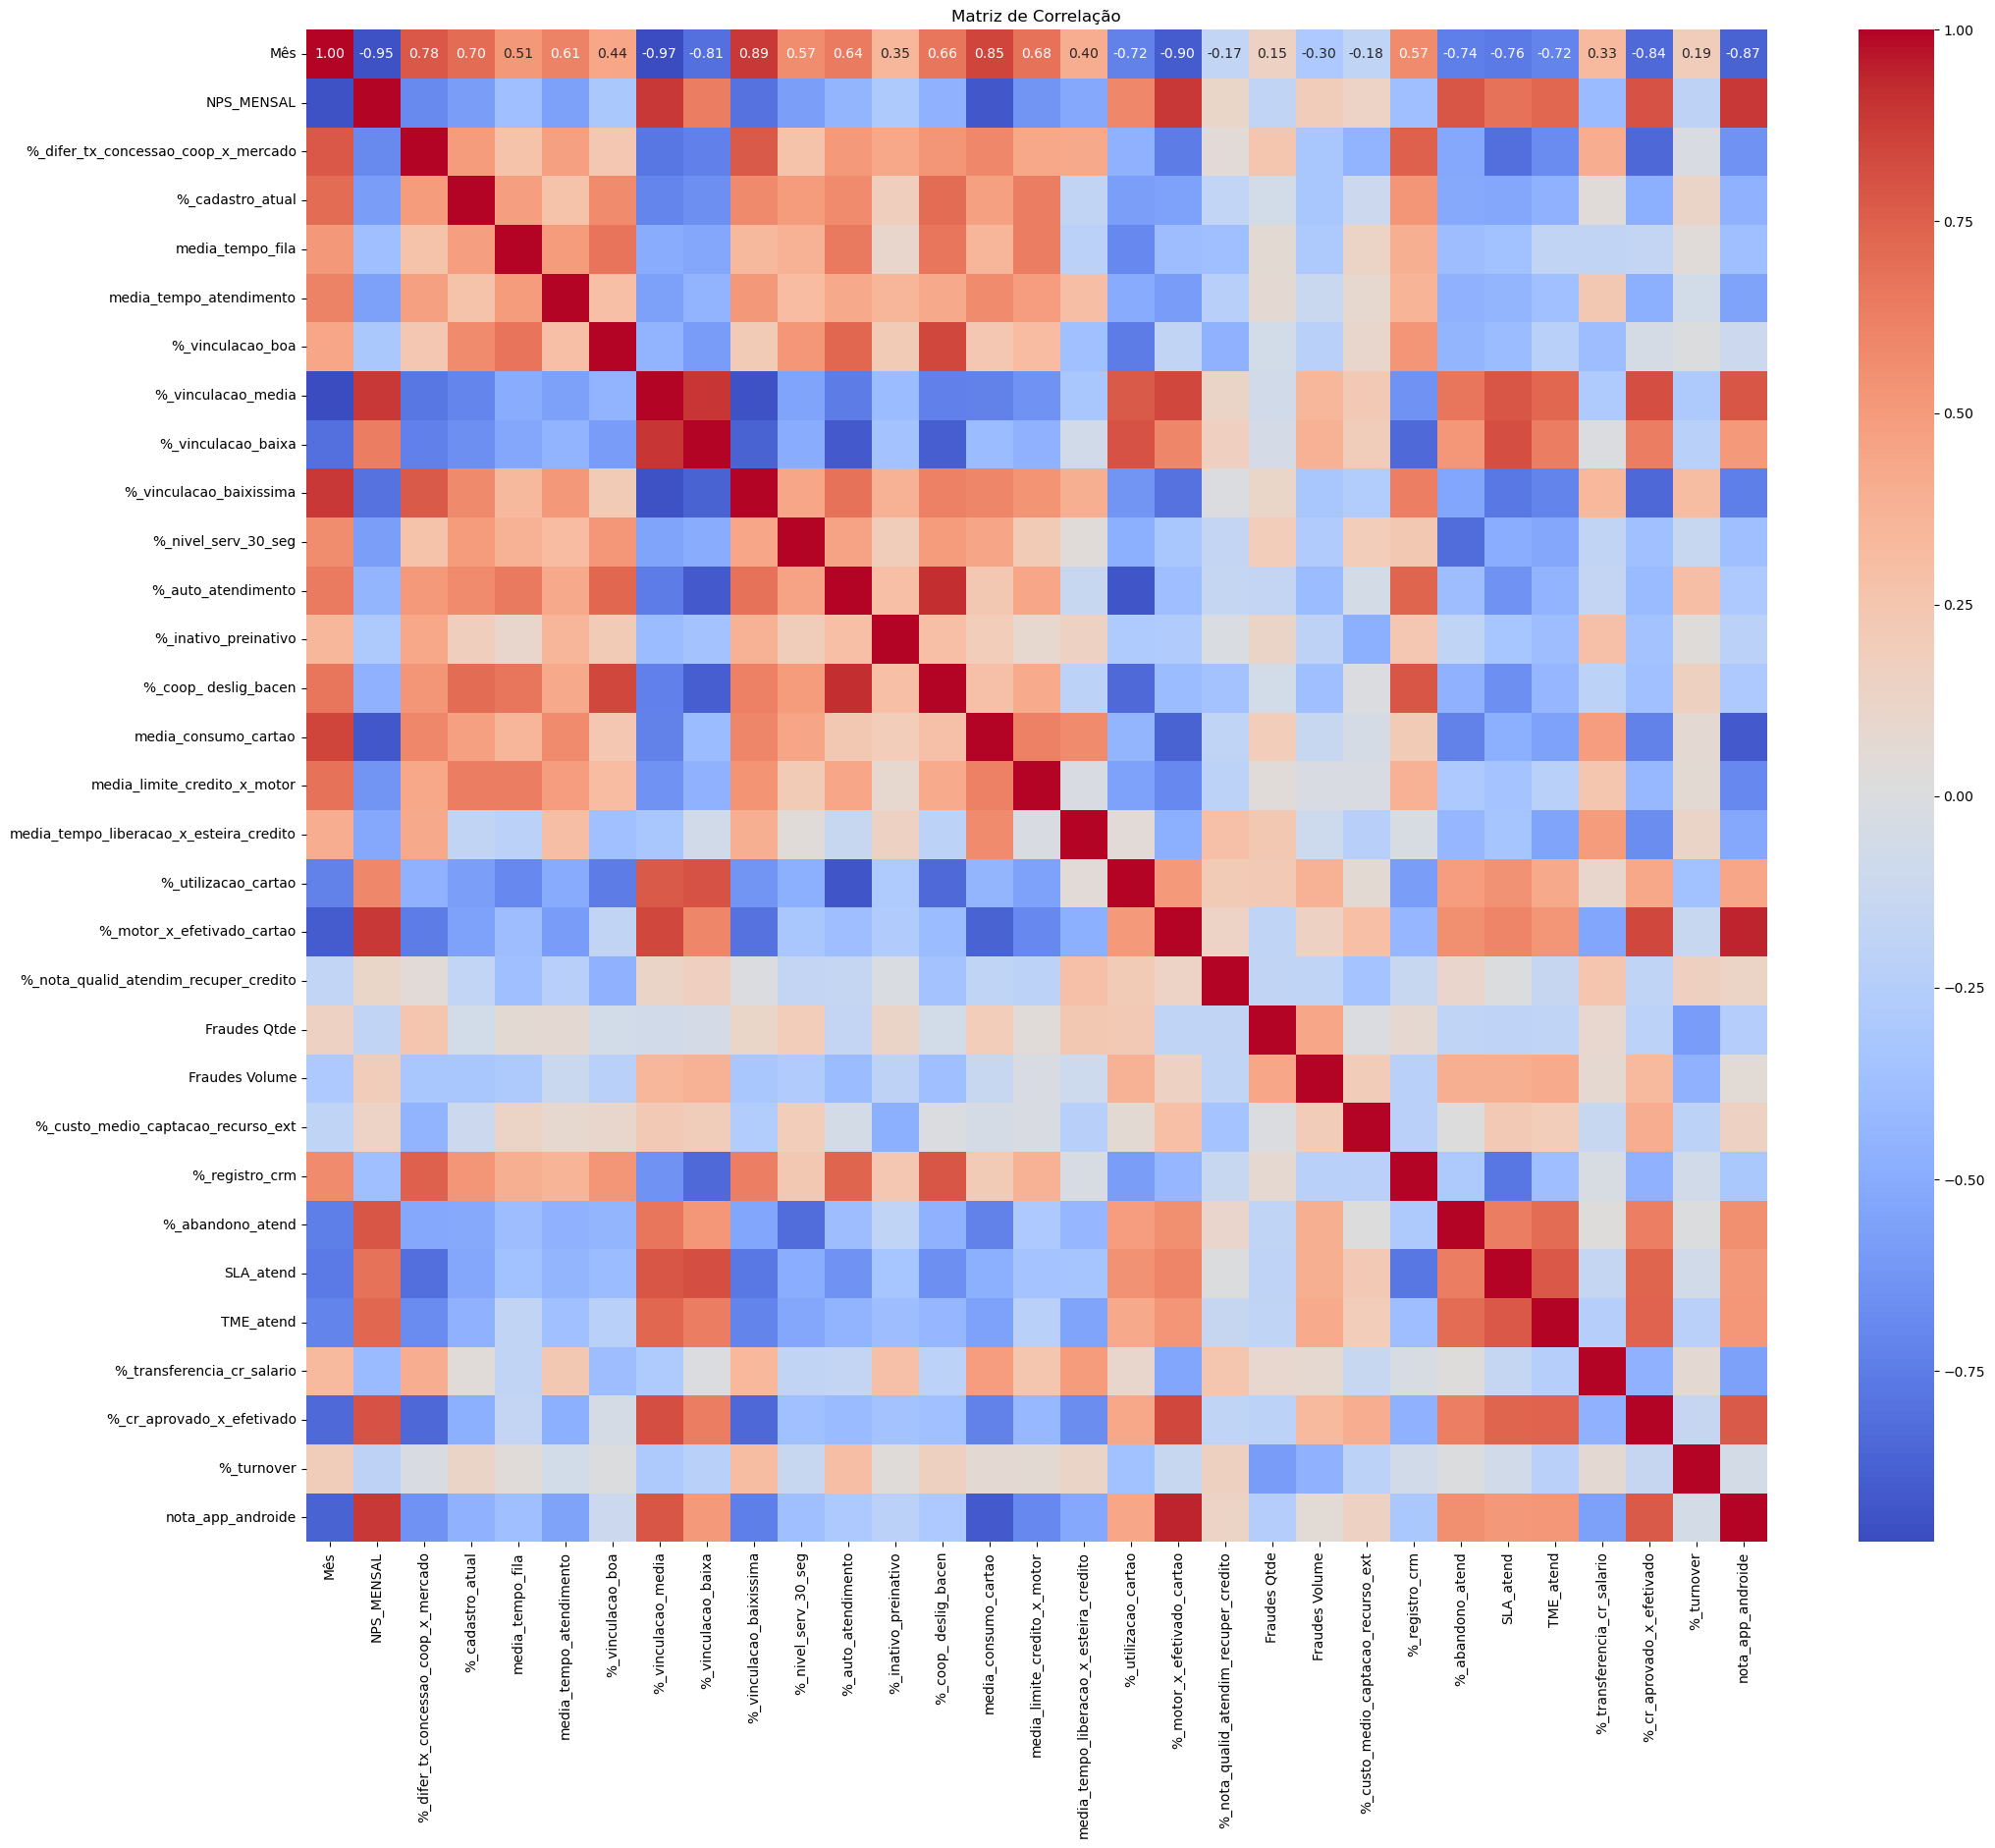

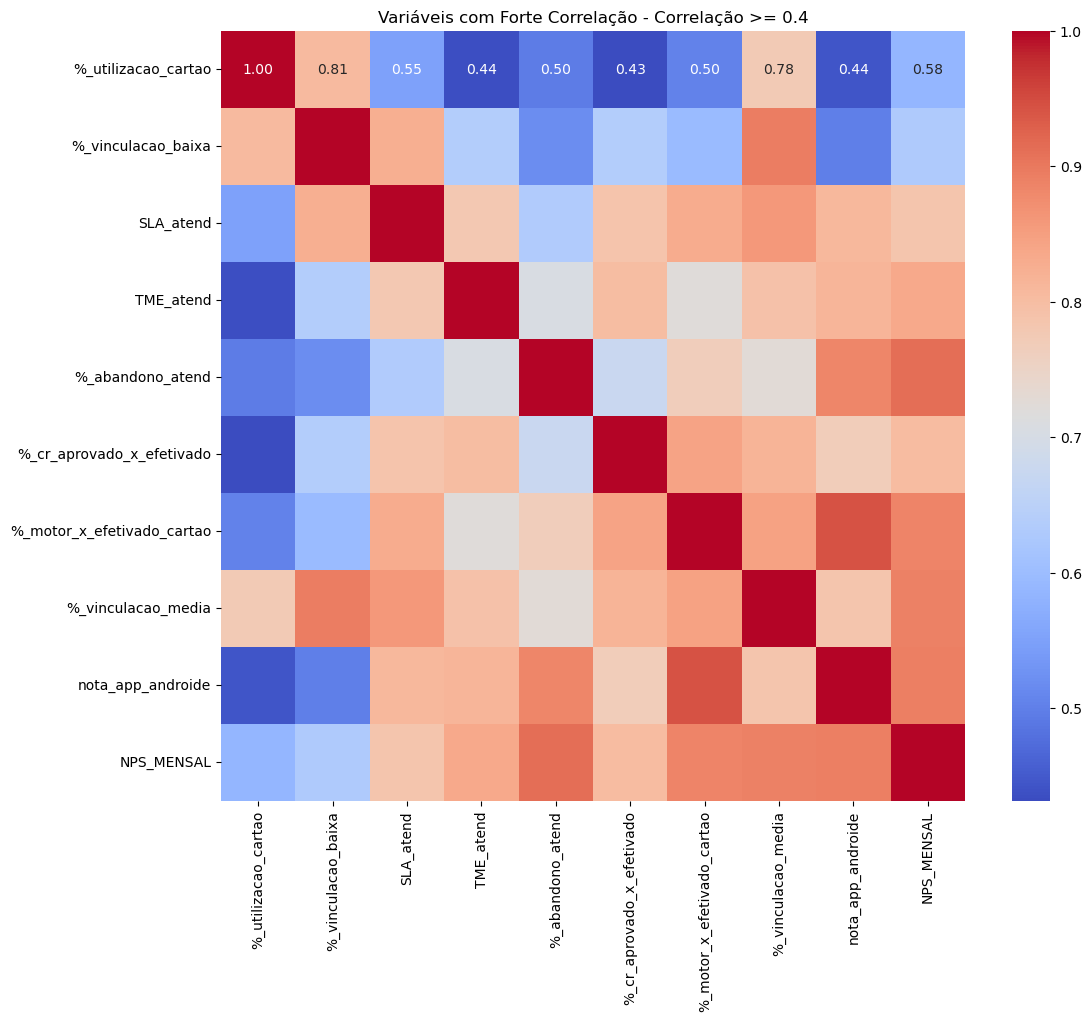

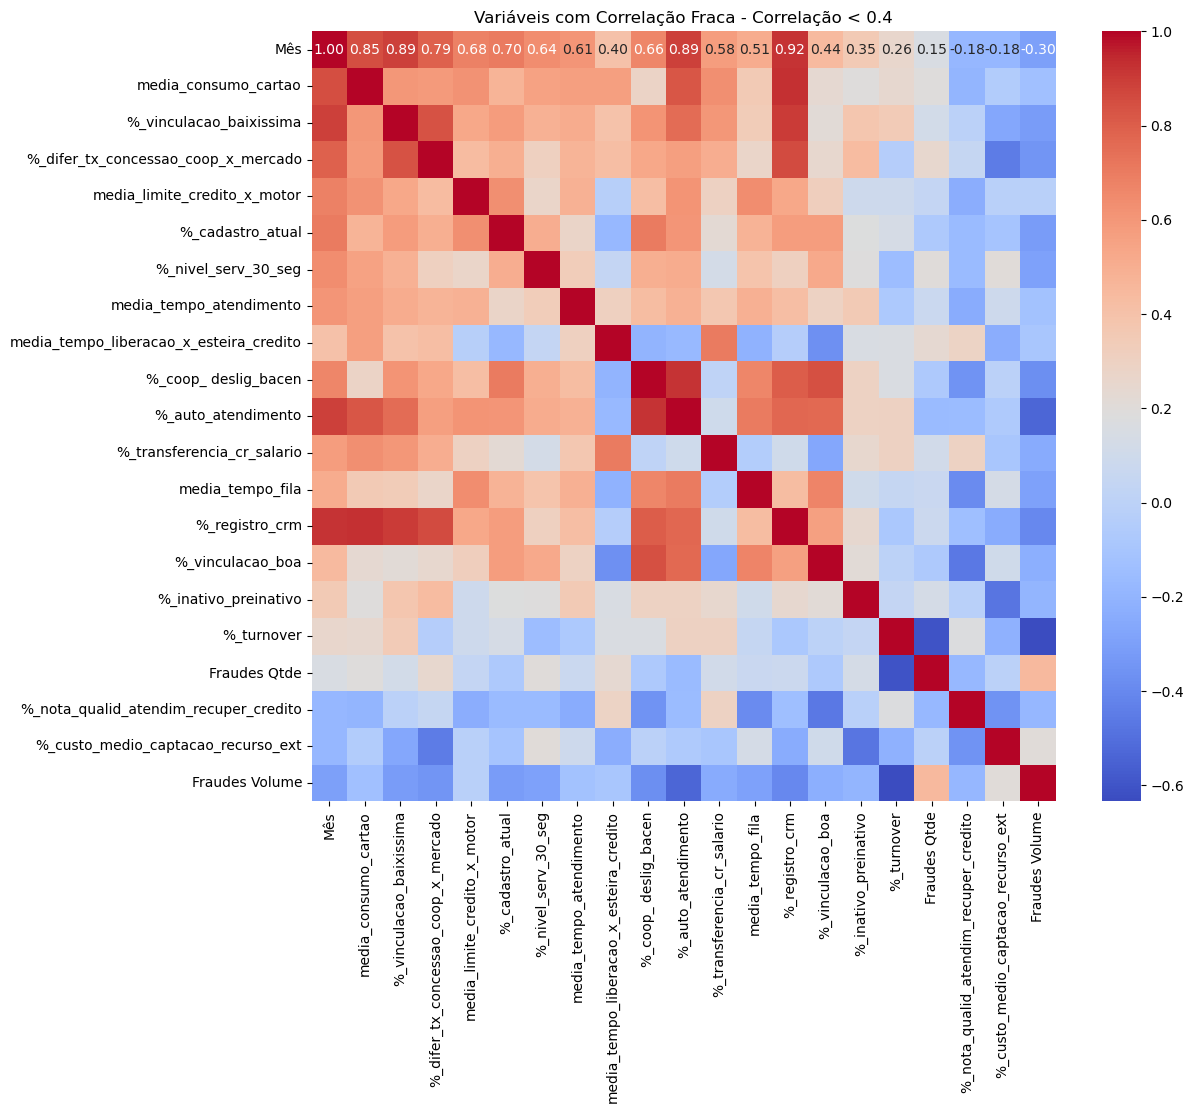

In [7]:
# matriz de correlação

matriz_correlacao = df_filtrado.corr()

correlacao_nps = matriz_correlacao['NPS_MENSAL'].sort_values()

# grupos de correlação

forte_correlacao = correlacao_nps[correlacao_nps >= 0.4].index.tolist()
correlacao_fraca = correlacao_nps[correlacao_nps < 0.4].index.tolist()

# visualização de todas as variãveis
plt.figure(figsize=(24, 20))
sns.heatmap(matriz_correlacao, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

# visualização das variáveis de forte correlação
plt.figure(figsize=(12, 10))
sns.heatmap(df[forte_correlacao].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Variáveis com Forte Correlação - Correlação >= 0.4')
plt.show()

# visualização das variáveis de correlação fraca
plt.figure(figsize=(12, 10))
sns.heatmap(df[correlacao_fraca].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Variáveis com Correlação Fraca - Correlação < 0.4')
plt.show()

### Regressão Linear Univariada


#### Base Completa

In [8]:
# Função para criar a regressão para cada variável

def analise_regressao_univariada (df, variaveis):
    resumo_resultado = {
        'Subgrupo A (R2>=0.50 & p<0.05)': [],
        'Subgrupo B(R2<0.50 &|| p>0.05)': []
    }
    
    for var in variaveis:
        # Transforma em número variáveis que estão em outro formato (statsmodel não aceita)
        df[var] = pd.to_numeric(df[var], errors='coerce')
        
        # Define preditores e targuet
        X = sm.add_constant(df[var]) # adiciona uma constante para o intercepto
        y = df['NPS_MENSAL']
        
        # Cria o modelo
        modelo = sm.OLS(y, X).fit()
        
        # Extrai o R2 e p-value
        r_quadrado = modelo.rsquared
        p_value = modelo.pvalues[1] # p-value apenas para os preditores
        
        # Agrupa métricas
        metricas = {
            'Variavel': var,
            'Coeficiente': modelo.params[1],
            'R2': r_quadrado,
            'p-value': p_value
        }
        
        # Categorização de acordo com o R2 e p-value
        if r_quadrado >= 0.50 and p_value < 0.05:
            resumo_resultado['Subgrupo A (R2>=0.50 & p<0.05)'].append(metricas)
        else:
            resumo_resultado['Subgrupo B(R2<0.50 &|| p>0.05)'].append(metricas)
            
    return resumo_resultado


In [9]:
# Variáveis com forte correlação
resumo_forte_correlacao = analise_regressao_univariada(df_filtrado, forte_correlacao)

# Variáveis com correlação fraca
resumo_correlacao_fraca = analise_regressao_univariada(df_filtrado, correlacao_fraca)

In [10]:
# Função para imprimir os resultados
def print_resultados(resultados):
    for subgroupo, lista_metricas in resultados.items():
        print(f'Resultados para {subgroupo}:')
        for metricas in lista_metricas:
            print(f"Variavel: {metricas['Variavel']}, Coeficiente: {metricas['Coeficiente']:.4f}, "
                  f"R2: {metricas['R2']:.4f}, p-value: {metricas['p-value']: .4f}")
            print()

In [11]:
# Imprime os resultados
print('Análise das variáveis de Forte Correlação')
print_resultados(resumo_forte_correlacao)
print('Análise das variáveis de Correlação Fraca')
print_resultados(resumo_correlacao_fraca)

Análise das variáveis de Forte Correlação
Resultados para Subgrupo A (R2>=0.50 & p<0.05):
Variavel: TME_atend, Coeficiente: 18.9212, R2: 0.5223, p-value:  0.0000

Variavel: %_abandono_atend, Coeficiente: 143.3711, R2: 0.6239, p-value:  0.0000

Variavel: %_cr_aprovado_x_efetivado, Coeficiente: 30.7016, R2: 0.6447, p-value:  0.0000

Variavel: %_motor_x_efetivado_cartao, Coeficiente: 42.6639, R2: 0.7862, p-value:  0.0000

Variavel: %_vinculacao_media, Coeficiente: 577.4387, R2: 0.7916, p-value:  0.0000

Variavel: nota_app_androide, Coeficiente: 30.6341, R2: 0.7958, p-value:  0.0000

Variavel: NPS_MENSAL, Coeficiente: 1.0000, R2: 1.0000, p-value:  0.0000

Resultados para Subgrupo B(R2<0.50 &|| p>0.05):
Variavel: %_utilizacao_cartao, Coeficiente: 40.7036, R2: 0.3422, p-value:  0.0017

Variavel: %_vinculacao_baixa, Coeficiente: 544.3301, R2: 0.3974, p-value:  0.0006

Variavel: SLA_atend, Coeficiente: 2.9736, R2: 0.4624, p-value:  0.0001

Análise das variáveis de Correlação Fraca
Resultados p

#### Base removendo variável com multicolinearidade, correlação que não faz sentido e orientação da área de CX


In [12]:
# %_cadastro_atual, %_vinculacao_boa, %_vinculacao_media, %_vinculação_baixissima, %_vinculação_baixa,
# %_registro_crm, %_difer_tx_concessao_coop_x_mercado, Fraudes Qtde, Fraudes Volume, '%_nota_qualid_atendim_recuper_credito', '%_custo_medio_captacao_recurso_ext', '%_transferencia_cr_salario'
df_filtrado_2 = df_filtrado.drop(['Mês', '%_cadastro_atual', '%_vinculacao_boa', '%_vinculacao_media', '%_vinculacao_baixa','%_vinculacao_baixissima', '%_registro_crm', '%_difer_tx_concessao_coop_x_mercado', 'Fraudes Qtde', 'Fraudes Volume', '%_nota_qualid_atendim_recuper_credito', '%_custo_medio_captacao_recurso_ext', '%_transferencia_cr_salario'], axis=1)

In [13]:
matriz_correlacao_df_filtrado_2 = df_filtrado_2.corr()

correlacao_nps_df_filtrado_2 = matriz_correlacao_df_filtrado_2['NPS_MENSAL'].sort_values()

# grupos de correlação

forte_correlacao_df_filtrado_2 = correlacao_nps_df_filtrado_2[correlacao_nps_df_filtrado_2 >= 0.4].index.tolist()
correlacao_fraca_df_filtrado_2 = correlacao_nps_df_filtrado_2[correlacao_nps_df_filtrado_2 < 0.4].index.tolist()

# Variáveis com forte correlação
resumo_forte_correlacao_df_filtrado_2 = analise_regressao_univariada(df_filtrado_2, forte_correlacao_df_filtrado_2)

# Variáveis com correlação fraca
resumo_correlacao_fraca_df_filtrado_2 = analise_regressao_univariada(df_filtrado_2, correlacao_fraca_df_filtrado_2)

# Imprime os resultados
print('Análise das variáveis de Forte Correlação com variáveis filtradas')
print_resultados(resumo_forte_correlacao_df_filtrado_2)
print('Análise das variáveis de Correlação Fraca com variáveis filtradas')
print_resultados(resumo_correlacao_fraca_df_filtrado_2)

Análise das variáveis de Forte Correlação com variáveis filtradas
Resultados para Subgrupo A (R2>=0.50 & p<0.05):
Variavel: TME_atend, Coeficiente: 18.9212, R2: 0.5223, p-value:  0.0000

Variavel: %_abandono_atend, Coeficiente: 143.3711, R2: 0.6239, p-value:  0.0000

Variavel: %_cr_aprovado_x_efetivado, Coeficiente: 30.7016, R2: 0.6447, p-value:  0.0000

Variavel: %_motor_x_efetivado_cartao, Coeficiente: 42.6639, R2: 0.7862, p-value:  0.0000

Variavel: nota_app_androide, Coeficiente: 30.6341, R2: 0.7958, p-value:  0.0000

Variavel: NPS_MENSAL, Coeficiente: 1.0000, R2: 1.0000, p-value:  0.0000

Resultados para Subgrupo B(R2<0.50 &|| p>0.05):
Variavel: %_utilizacao_cartao, Coeficiente: 40.7036, R2: 0.3422, p-value:  0.0017

Variavel: SLA_atend, Coeficiente: 2.9736, R2: 0.4624, p-value:  0.0001

Análise das variáveis de Correlação Fraca com variáveis filtradas
Resultados para Subgrupo A (R2>=0.50 & p<0.05):
Variavel: media_consumo_cartao, Coeficiente: -0.0114, R2: 0.8497, p-value:  0.0000

## Regressão Multivariada


In [14]:
# removendo mês

df_filtrado_multi = df_filtrado.drop(['Mês'], axis=1)

In [15]:
# Função para regressão multi

def teste_combinacao_variaveis(df, variavel_targuet, variaveis_preditoras):
    resultado = []
    for L in range(1, len(variaveis_preditoras)+1):
        for subset in itertools.combinations(variaveis_preditoras, L):
            preditores = list(subset)
            preditores_com_constante = sm.add_constant(df[preditores])
            modelo = sm.OLS(df[variavel_targuet], preditores_com_constante).fit()
            resultado.append((modelo.rsquared_adj, preditores, modelo))
            
    # ordena resultado por R2 ajustado em ordem descendente
    resultado_ordenado = sorted(resultado, key=lambda x: x[0], reverse=True)
    
    # imprime summary dos 5 maiores R2 ajustado
    for i, (rsquared_adj, preditores, modelo) in enumerate(resultado_ordenado[:5]):
        print(f"Modelo {i+1} com os preditores {preditores} apresentam um R2 ajustado: {rsquared_adj}")
        print(modelo.summary())
        print('\n\n')

### Base com variáveis de forte correlação

In [16]:
# Aplica a regressão

# variáveis de forte correlação
variaveis_preditoras_forte_correlacao = ['%_cr_aprovado_x_efetivado', '%_motor_x_efetivado_cartao', '%_vinculacao_media', 'nota_app_androide', 'SLA_atend', 'TME_atend', '%_abandono_atend', '%_utilizacao_cartao', '%_vinculacao_baixa']

teste_combinacao_variaveis(df_filtrado_multi, 'NPS_MENSAL', variaveis_preditoras_forte_correlacao)

Modelo 1 com os preditores ['%_cr_aprovado_x_efetivado', '%_vinculacao_media', 'nota_app_androide', 'SLA_atend', '%_abandono_atend', '%_vinculacao_baixa'] apresentam um R2 ajustado: 0.9725137836349828
                            OLS Regression Results                            
Dep. Variable:             NPS_MENSAL   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     148.4
Date:                Tue, 19 Mar 2024   Prob (F-statistic):           6.36e-15
Time:                        15:47:32   Log-Likelihood:                -34.931
No. Observations:                  26   AIC:                             83.86
Df Residuals:                      19   BIC:                             92.67
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
         

### Base com variáveis filtradas por multicolinearidade, baixa explicabilidade da correlação e decisão de CX

In [17]:
# Regressão df_filtrado_2

targuet_df_filtrado_2 = 'NPS_MENSAL'
preditores__df_filtrado_2 = [col for col in df_filtrado_2.columns if col != targuet_df_filtrado_2]

teste_combinacao_variaveis(df_filtrado_2, 'NPS_MENSAL', preditores__df_filtrado_2)

Modelo 1 com os preditores ['media_tempo_fila', '%_auto_atendimento', '%_inativo_preinativo', 'media_limite_credito_x_motor', 'media_tempo_liberacao_x_esteira_credito', '%_motor_x_efetivado_cartao', '%_abandono_atend', 'TME_atend', '%_cr_aprovado_x_efetivado', '%_turnover', 'nota_app_androide'] apresentam um R2 ajustado: 0.968389231186889
                            OLS Regression Results                            
Dep. Variable:             NPS_MENSAL   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     70.62
Date:                Tue, 19 Mar 2024   Prob (F-statistic):           2.63e-10
Time:                        15:53:11   Log-Likelihood:                -32.779
No. Observations:                  26   AIC:                             89.56
Df Residuals:                      14   BIC:                             104.7
Df Model:                  

### Base removendo variáveis df_filtrado_2 com valor p>0.05

In [18]:
# removendo variáveis com valor P>0.05: 'media_consumo_cartao', 'SLA_atend', '%_turnover'
variaveis_preditoras_significancia_baixa_df_filtrado_2 = ['media_tempo_fila', 'media_tempo_atendimento',
       '%_nivel_serv_30_seg', '%_inativo_preinativo',
       'media_limite_credito_x_motor', '%_auto_atendimento',
       'media_tempo_liberacao_x_esteira_credito', '%_utilizacao_cartao',
       '%_motor_x_efetivado_cartao', '%_abandono_atend',
       'TME_atend', '%_cr_aprovado_x_efetivado',
       'nota_app_androide', '%_coop_ deslig_bacen']
teste_combinacao_variaveis(df_filtrado_2, 'NPS_MENSAL', variaveis_preditoras_significancia_baixa_df_filtrado_2)

Modelo 1 com os preditores ['media_tempo_fila', 'media_limite_credito_x_motor', '%_auto_atendimento', 'media_tempo_liberacao_x_esteira_credito', '%_motor_x_efetivado_cartao', '%_abandono_atend', 'TME_atend', '%_cr_aprovado_x_efetivado', 'nota_app_androide'] apresentam um R2 ajustado: 0.9639214336180675
                            OLS Regression Results                            
Dep. Variable:             NPS_MENSAL   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     75.21
Date:                Tue, 19 Mar 2024   Prob (F-statistic):           2.19e-11
Time:                        15:53:49   Log-Likelihood:                -36.233
No. Observations:                  26   AIC:                             92.47
Df Residuals:                      16   BIC:                             105.0
Df Model:                           9                           

In [19]:
df_selecionado = df_filtrado_2[['NPS_MENSAL','media_tempo_fila', 'media_tempo_atendimento', '%_nivel_serv_30_seg', 'media_limite_credito_x_motor', '%_auto_atendimento', 'media_tempo_liberacao_x_esteira_credito', '%_motor_x_efetivado_cartao', '%_abandono_atend', 'TME_atend', '%_cr_aprovado_x_efetivado']]
df_selecionado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 11 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   NPS_MENSAL                               26 non-null     int64  
 1   media_tempo_fila                         26 non-null     float64
 2   media_tempo_atendimento                  26 non-null     float64
 3   %_nivel_serv_30_seg                      26 non-null     float64
 4   media_limite_credito_x_motor             26 non-null     int64  
 5   %_auto_atendimento                       26 non-null     float64
 6   media_tempo_liberacao_x_esteira_credito  26 non-null     float64
 7   %_motor_x_efetivado_cartao               26 non-null     float64
 8   %_abandono_atend                         26 non-null     float64
 9   TME_atend                                26 non-null     float64
 10  %_cr_aprovado_x_efetivado                26 non-null

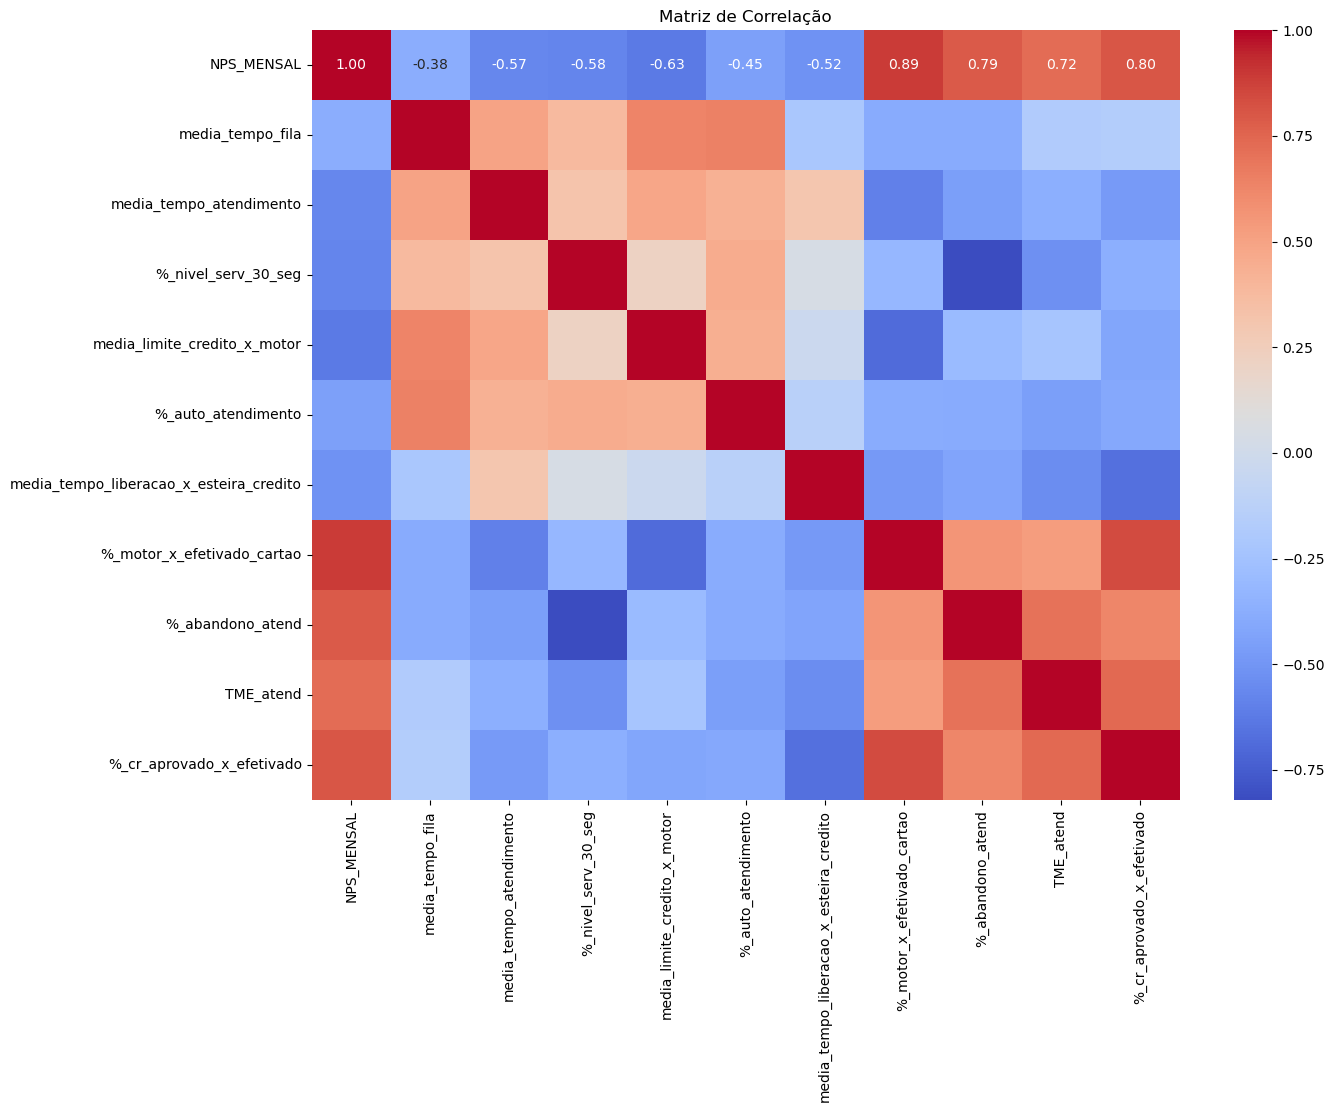

In [20]:
# matriz de correlação

matriz_correlacao_df_selecionado = df_selecionado.corr()

correlacao_nps_df_selecionado = matriz_correlacao_df_selecionado['NPS_MENSAL'].sort_values()


# visualização de todas as variãveis
plt.figure(figsize=(14, 10))
sns.heatmap(matriz_correlacao_df_selecionado, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

In [21]:
# redução de dimensionalidade através da identificação de multicolinearidade com análise VIF

vif = pd.DataFrame()
vif['variaveis'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
display(vif)

NameError: name 'X' is not defined